# Part 4: Hedging Strategy Implementation

## Tasks
- **Calculate daily hedge ratio:**
  
  $h_t = \beta_t \times \frac{\text{Portfolio Value}}{\text{SPY Price}}$
- **Short SPY dynamically**, rebalancing daily
- **Simulate hedged returns:**
  
  $r_{hp,t} = r_{p,t} - \beta_t \times r_{mkt,t}$
- **Update portfolio value with hedging logic**

## Deliverables
- Hedge ratio and short SPY position
- Time series of hedged portfolio value and returns
- Comparison with unhedged values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
print("Libraries imported successfully!")

Libraries imported successfully!


### Task 1: Import Required Data
Import SPY prices, portfolio values, and beta estimates (or calculate rolling beta if missing).

In [2]:
# Load SPY prices and calculate returns
spy_data = yf.download('SPY', start='2020-01-01', 
                       end='2025-07-31', progress=False)
spy = spy_data['Close'] if 'Close' in spy_data.columns else spy_data.squeeze()
spy_returns = spy.pct_change().dropna()
print(f"✓ SPY data loaded: {len(spy)} prices")


# Load portfolio data from Part 2
port_path = '../Part 2: Initial Portfolio Construction/' + \
           'equal_weight_portfolio_results.csv'
port = pd.read_csv(port_path, index_col=0, parse_dates=True)
portfolio_value = port['Portfolio_Value']
portfolio_returns = port['Portfolio_Return']
print(f"✓ Portfolio data loaded: {len(portfolio_value)} observations")


# Load beta data from Part 3 or create rolling beta calculation
beta_path = '../Part 3: Market Exposure Estimation/' + \
           'portfolio_beta_timeseries.csv'
beta_data = pd.read_csv(beta_path, index_col=0, parse_dates=True)
betas = beta_data['Beta'] if 'Beta' in beta_data.columns else \
        beta_data.iloc[:,0]
print(f"✓ Beta data loaded: {len(betas)} observations")

✓ SPY data loaded: 1401 prices
✓ Portfolio data loaded: 1254 observations
✓ Beta data loaded: 1254 observations


### Task 2: Calculate Daily Hedge Ratio and Short SPY Position
Compute the daily hedge ratio and determine the number of SPY shares to short.

In [3]:
# Align all data to common dates
print("Aligning data to common dates...")
common_dates = (portfolio_value.index
                .intersection(spy.index)
                .intersection(betas.index)
                .intersection(portfolio_returns.index)
                .intersection(spy_returns.index))

print(f"Common date range: {common_dates.min()} to " + \
      f"{common_dates.max()} ({len(common_dates)} days)")

# Align all series
pv = portfolio_value.loc[common_dates]
spy_p = spy.loc[common_dates] 
beta = betas.loc[common_dates]
pr = portfolio_returns.loc[common_dates]
mr = spy_returns.loc[common_dates]

# Convert DataFrame columns to Series if necessary
if isinstance(spy_p, pd.DataFrame):
    spy_p = spy_p.iloc[:,0]
if isinstance(mr, pd.DataFrame):
    mr = mr.iloc[:,0]

# Calculate hedge ratio: h_t = beta_t * (Portfolio Value / SPY Price)

hedge_ratio = beta * (pv / spy_p)
short_spy_shares = -hedge_ratio  # Number of SPY shares to short

print(f"Average beta: {beta.mean():.3f}")
print(f"Hedge ratio calculated for {len(hedge_ratio)} days")

# Deliverable 1: Show hedge ratios and short SPY positions
hedge_summary = pd.DataFrame({
    'Beta': beta,
    'Hedge_Ratio': hedge_ratio, 
    'Short_SPY_Shares': short_spy_shares
})
print("\nFirst 5 hedge ratios and short SPY positions:")
display(hedge_summary.head())

Aligning data to common dates...
Common date range: 2020-08-07 00:00:00 to 2025-07-30 00:00:00 (1250 days)
Average beta: 0.917
Hedge ratio calculated for 1250 days

First 5 hedge ratios and short SPY positions:


,Beta,Hedge_Ratio,Short_SPY_Shares
2020-08-07,0.917477,294.512154,-294.512154
2020-08-10,0.917477,295.434925,-295.434925
2020-08-11,0.917477,297.147771,-297.147771
2020-08-12,0.917477,295.289627,-295.289627
2020-08-13,0.917477,295.165076,-295.165076


### Task 3: Simulate Hedged Returns
Calculate the daily returns of the hedged portfolio using the hedge ratio.

In [4]:
# Calculate hedged returns: r_hp,t = r_p,t - beta_t * r_mkt,t
hedged_returns = pr - beta * mr

print(f"✓ Hedged returns calculated")
print(f"Original portfolio - Mean: {pr.mean()*252:.2%}, " + \
      f"Vol: {pr.std()*np.sqrt(252):.2%}")
print(f"Hedged portfolio   - Mean: {hedged_returns.mean()*252:.2%}, " + \
      f"Vol: {hedged_returns.std()*np.sqrt(252):.2%}")
print(f"Correlation with market - Original: {pr.corr(mr):.3f}, " + \
      f"Hedged: {hedged_returns.corr(mr):.3f}")

# Deliverable 2a: Show first 5 hedged returns
print("\nFirst 5 hedged returns:")
display(hedged_returns.head())

✓ Hedged returns calculated
Original portfolio - Mean: 14.55%, Vol: 17.12%
Hedged portfolio   - Mean: 0.43%, Vol: 4.52%
Correlation with market - Original: 0.957, Hedged: 0.002

First 5 hedged returns:


2020-08-07   -0.000658
2020-08-10    0.003389
2020-08-11    0.005069
2020-08-12   -0.005190
2020-08-13   -0.000570
dtype: float64

### Task 4: Update Portfolio Value with Hedging Logic
Apply the hedged returns to simulate the evolution of the hedged portfolio value.

In [5]:
# Calculate hedged portfolio value evolution
initial_value = 100000  # Initial portfolio value
hedged_portfolio_value = initial_value * (1 + hedged_returns).cumprod()

# Ensure the first value is exactly the initial value
hedged_portfolio_value.iloc[0] = initial_value

# Performance summary
final_unhedged = pv.iloc[-1]
final_hedged = hedged_portfolio_value.iloc[-1]
unhedged_return = (final_unhedged / initial_value) - 1
hedged_return = (final_hedged / initial_value) - 1

print(f"✓ Portfolio value evolution calculated")
print(f"Initial value: ${initial_value:,.0f}")
print(f"Final unhedged: ${final_unhedged:,.0f} " + \
      f"(Return: {unhedged_return:.2%})")
print(f"Final hedged: ${final_hedged:,.0f} " + \
      f"(Return: {hedged_return:.2%})")

# Deliverable 2b: Show first 5 hedged portfolio values
portfolio_comparison = pd.DataFrame({
    'Unhedged_Value': pv,
    'Hedged_Value': hedged_portfolio_value,
    'Hedged_Return': hedged_returns
})
print("\nFirst 5 hedged portfolio values:")
display(portfolio_comparison.head())
print(f"\nLast 5 hedged portfolio values:")
display(portfolio_comparison.tail())

✓ Portfolio value evolution calculated
Initial value: $100,000
Final unhedged: $191,362 (Return: 91.36%)
Final hedged: $101,617 (Return: 1.62%)

First 5 hedged portfolio values:


,Unhedged_Value,Hedged_Value,Hedged_Return
2020-08-07,100000.000000,100000.000000,-0.000658
2020-08-10,100613.150620,100272.853863,0.003389
2020-08-11,100361.130310,100781.101451,0.005069
2020-08-12,101124.066530,100258.059637,-0.005190
2020-08-13,100898.681586,100200.890993,-0.000570



Last 5 hedged portfolio values:


,Unhedged_Value,Hedged_Value,Hedged_Return
2025-07-24,192457.425467,102354.021310,-0.002303
2025-07-25,193002.753647,102096.454595,-0.002516
2025-07-28,192039.687549,101621.221514,-0.004655
2025-07-29,191824.277025,101745.386430,0.001222
2025-07-30,191362.349787,101617.088041,-0.001261


### Deliverable 3: Comparison with Unhedged Values
Visualize and compare the performance of the hedged and unhedged portfolios.

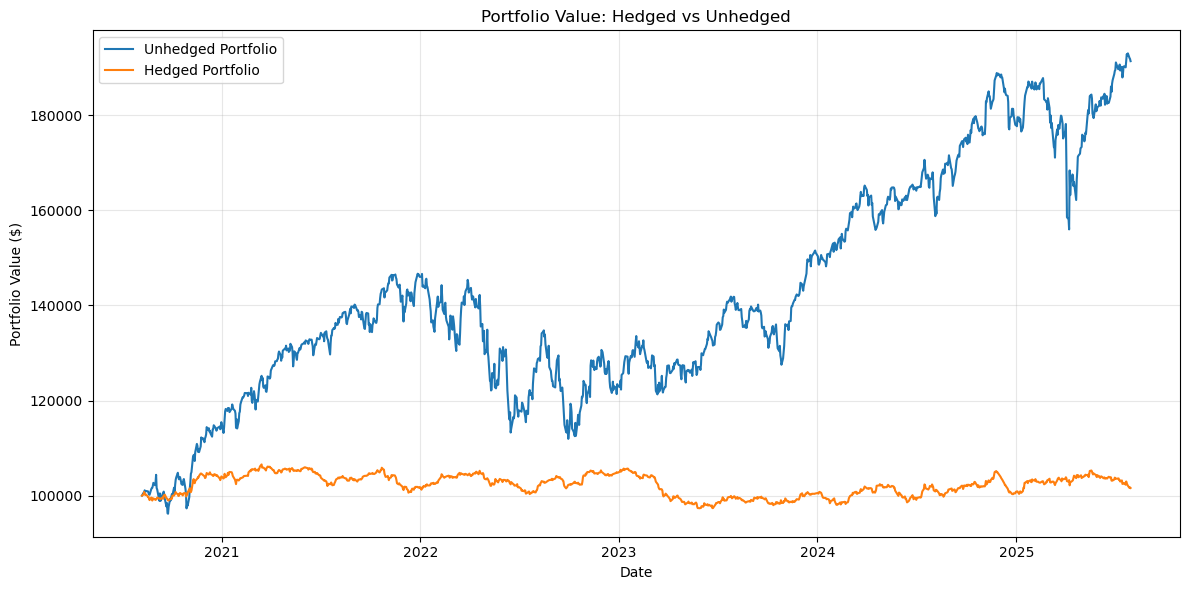

In [6]:
plt.figure(figsize=(12,6))
plt.plot(pv, label='Unhedged Portfolio')
plt.plot(hedged_portfolio_value, label='Hedged Portfolio')
plt.title('Portfolio Value: Hedged vs Unhedged')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Data Export for Part 5
Export the hedged and unhedged portfolio time series for use in the next analysis part.

In [7]:
# Save hedged vs unhedged timeseries data for Part 5 backtesting
timeseries_data = pd.DataFrame({
    'Date': portfolio_comparison.index,
    'Unhedged_Portfolio_Value': portfolio_comparison['Unhedged_Value'],
    'Hedged_Portfolio_Value': portfolio_comparison['Hedged_Value'],
    'Daily_Hedge_Ratio': hedge_ratio
})

# Save to CSV for Part 5 analysis
timeseries_data.to_csv('hedge_and_no_hedge_timeseries.csv', index=False)
print("✓ Hedged and unhedged timeseries data saved to " + \
      "'hedge_and_no_hedge_timeseries.csv'")

print(f"\nData shape: {timeseries_data.shape}")
print(f"Date range: {timeseries_data['Date'].iloc[0]} to " + \
      f"{timeseries_data['Date'].iloc[-1]}")

# Calculate correlation metrics for summary
correlation_before = pr.corr(mr)
correlation_after = hedged_returns.corr(mr)

# Summary of hedging effectiveness
print("\n=== Hedging Strategy Summary ===")
print(f"Unhedged portfolio return: {unhedged_return:.2%}")
print(f"Hedged portfolio return: {hedged_return:.2%}")
print(f"Alpha isolation impact: " + \
      f"{hedged_return - unhedged_return:.2%}")
print(f"Correlation with SPY reduced from {correlation_before:.3f} " + \
      f"to {correlation_after:.3f}")
print(f"Volatility reduction: " + \
      f"{((pr.std() - hedged_returns.std()) / pr.std()) * 100:.1f}%")

✓ Hedged and unhedged timeseries data saved to 'hedge_and_no_hedge_timeseries.csv'

Data shape: (1250, 4)
Date range: 2020-08-07 00:00:00 to 2025-07-30 00:00:00

=== Hedging Strategy Summary ===
Unhedged portfolio return: 91.36%
Hedged portfolio return: 1.62%
Alpha isolation impact: -89.75%
Correlation with SPY reduced from 0.957 to 0.002
Volatility reduction: 73.6%
